In [3]:
!pip install scikit-image

                                              0.0/22.9 MB ? eta -:--:--
                                              0.0/22.9 MB ? eta -:--:--
                                             0.0/22.9 MB 435.7 kB/s eta 0:00:53
                                             0.0/22.9 MB 435.7 kB/s eta 0:00:53
                                             0.0/22.9 MB 435.7 kB/s eta 0:00:53
                                             0.0/22.9 MB 164.3 kB/s eta 0:02:20
                                             0.1/22.9 MB 245.8 kB/s eta 0:01:33
                                             0.1/22.9 MB 275.8 kB/s eta 0:01:23
                                             0.1/22.9 MB 275.8 kB/s eta 0:01:23
                                             0.1/22.9 MB 261.9 kB/s eta 0:01:27
                                             0.1/22.9 MB 304.6 kB/s eta 0:01:15
                                             0.2/22.9 MB 296.2 kB/s eta 0:01:17
                                             0.2/22.9 MB

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\shivani\\AppData\\Local\\Programs\\Python\\Python39\\Lib\\site-packages\\~il\\_imaging.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [39]:
import numpy as np
import cv2
import os
import random
from skimage.io import imread
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D,MaxPooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from IPython.display import Audio

In [40]:
train_dir = r'D:\major projects shivani\ML Facial recognition to detect mood and suggest songs accordingly\train'
test_dir = r'D:\major projects shivani\ML Facial recognition to detect mood and suggest songs accordingly\test'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path +"/" +expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


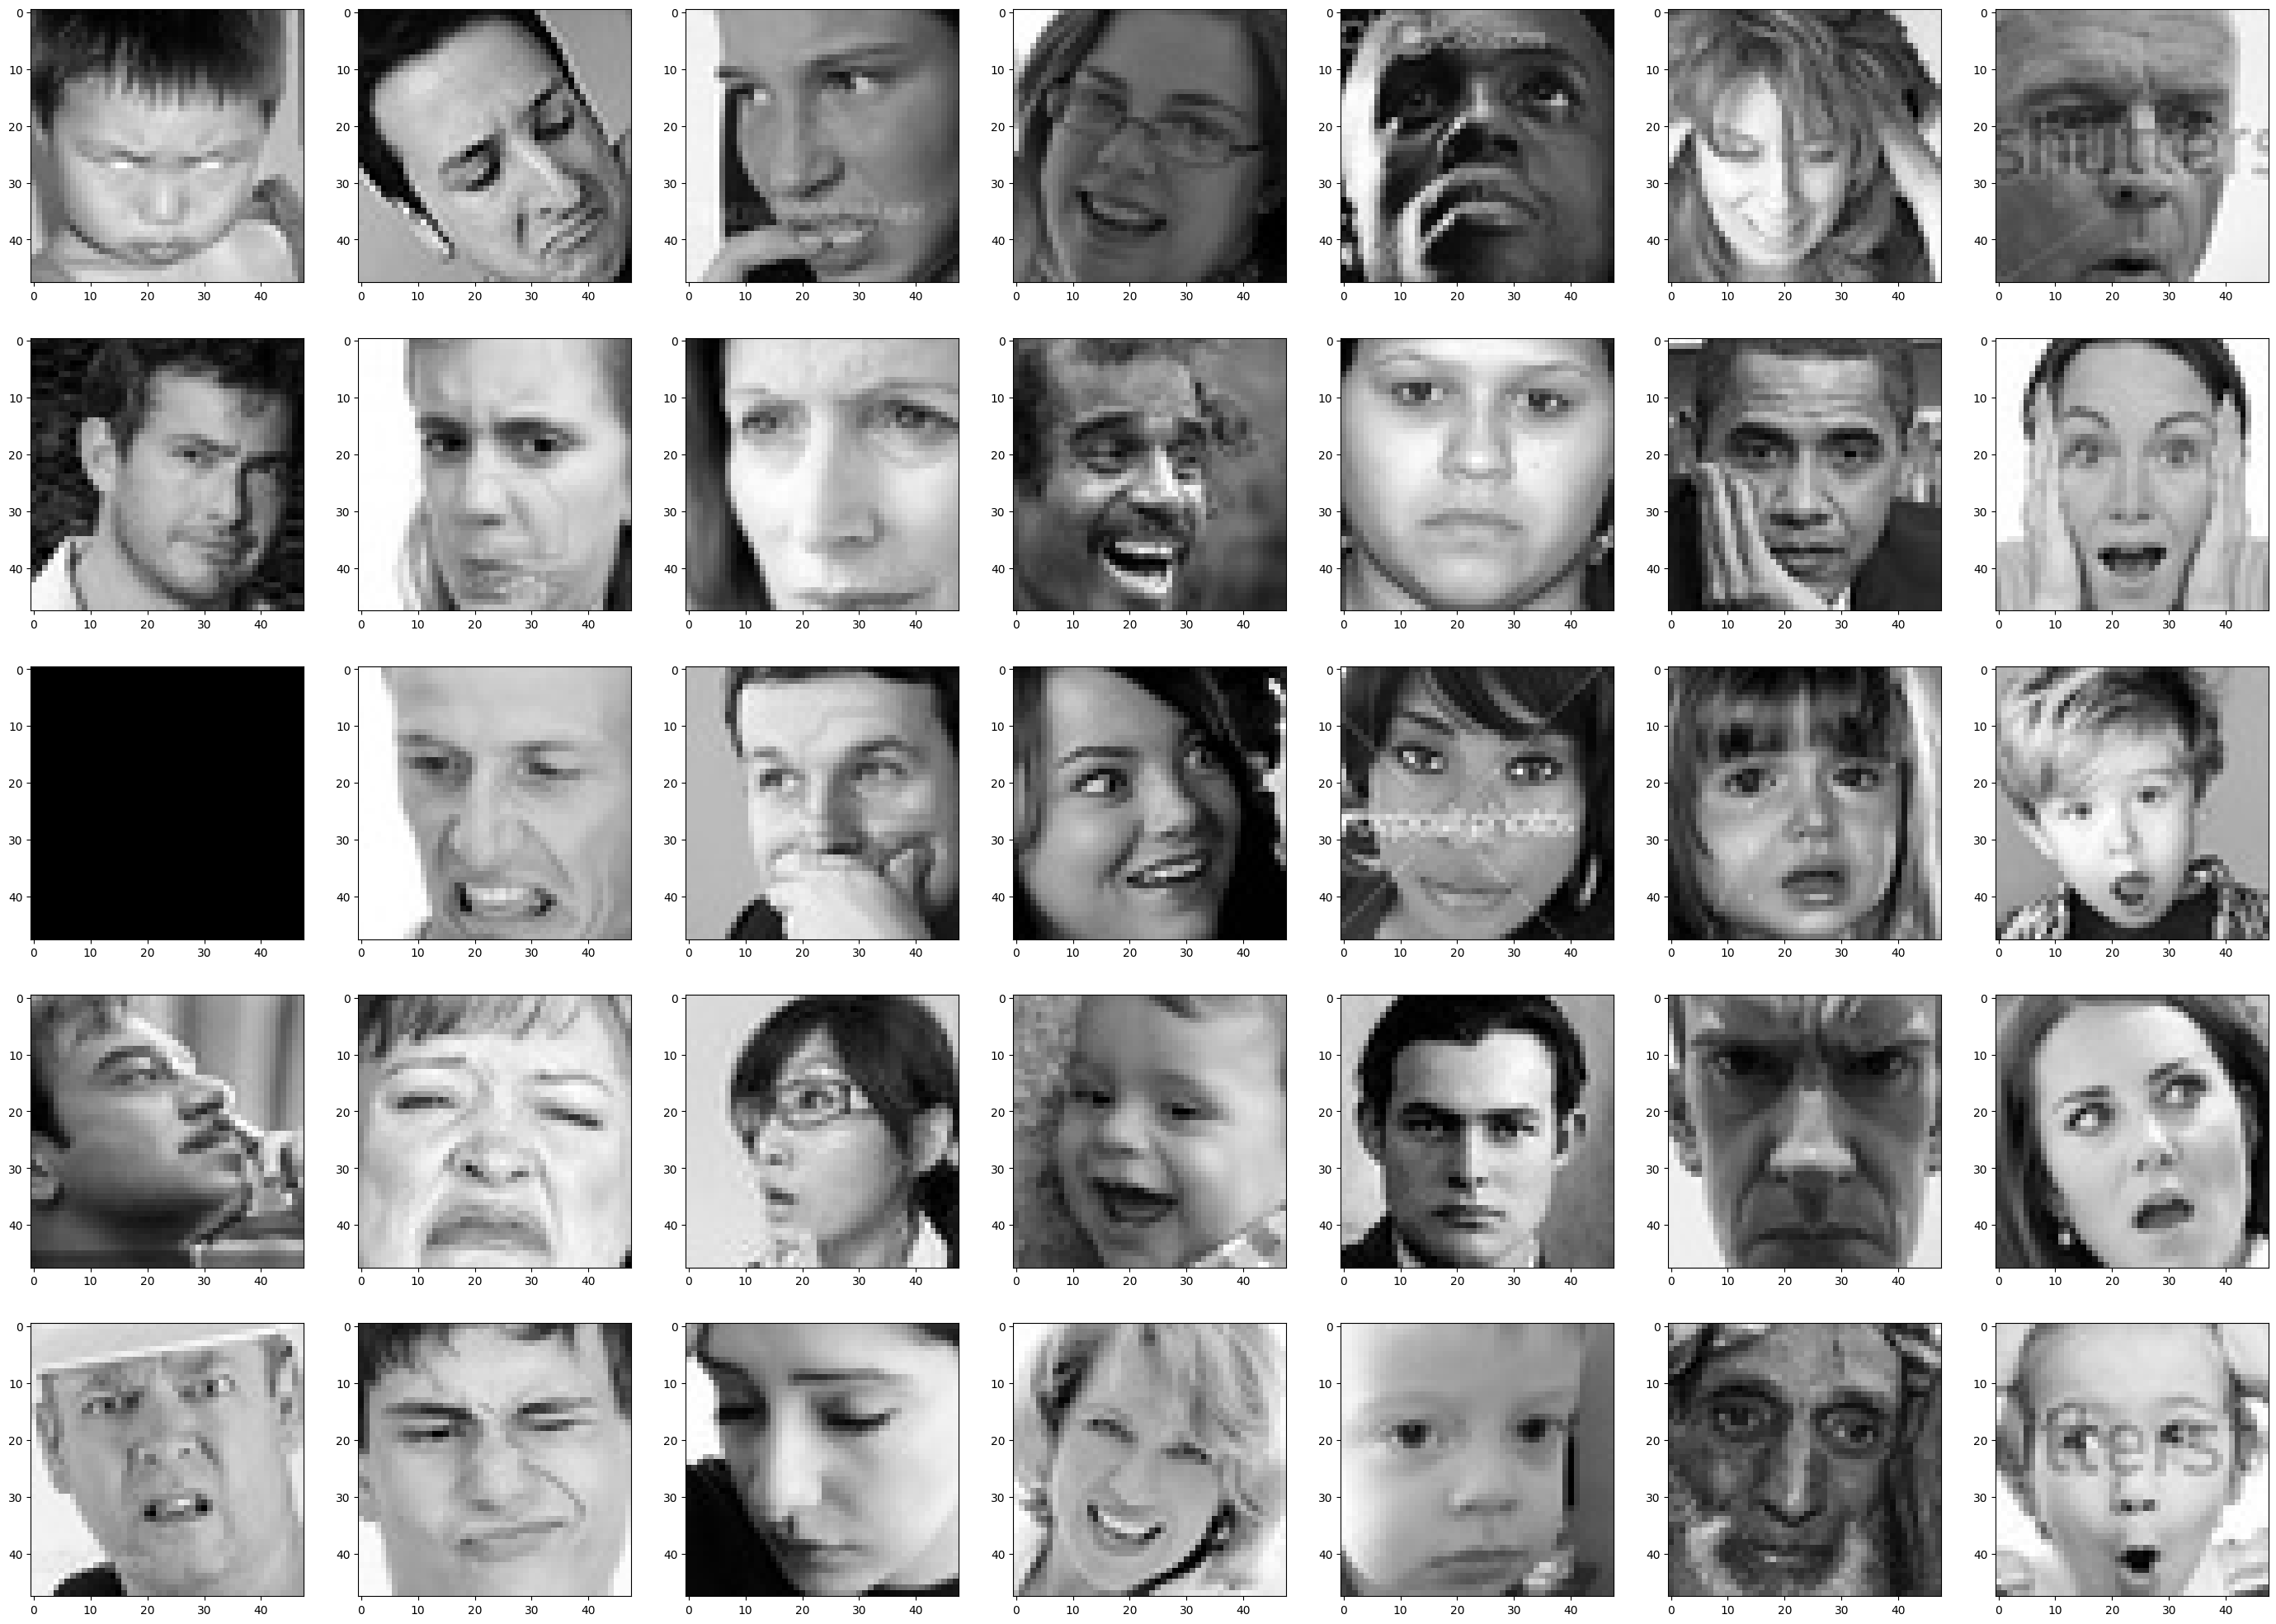

In [41]:
from skimage.io import imread
train_dir = "D:\\major projects shivani\\ML Facial recognition to detect mood and suggest songs accordingly\\train\\"
test_dir = "D:\\major projects shivani\\ML Facial recognition to detect mood and suggest songs accordingly\\test\\"
total_labels = len(os.listdir(train_dir))

fig, ax = plt.subplots(nrows=5, ncols=total_labels, figsize=(35, 25))
for x in range(5):
    for y,v in zip(range(total_labels),os.listdir(train_dir)):
        ax[x][y].imshow(imread(train_dir+v+'/'+os.listdir(train_dir+v)[x]), cmap='gray')

plt.show()

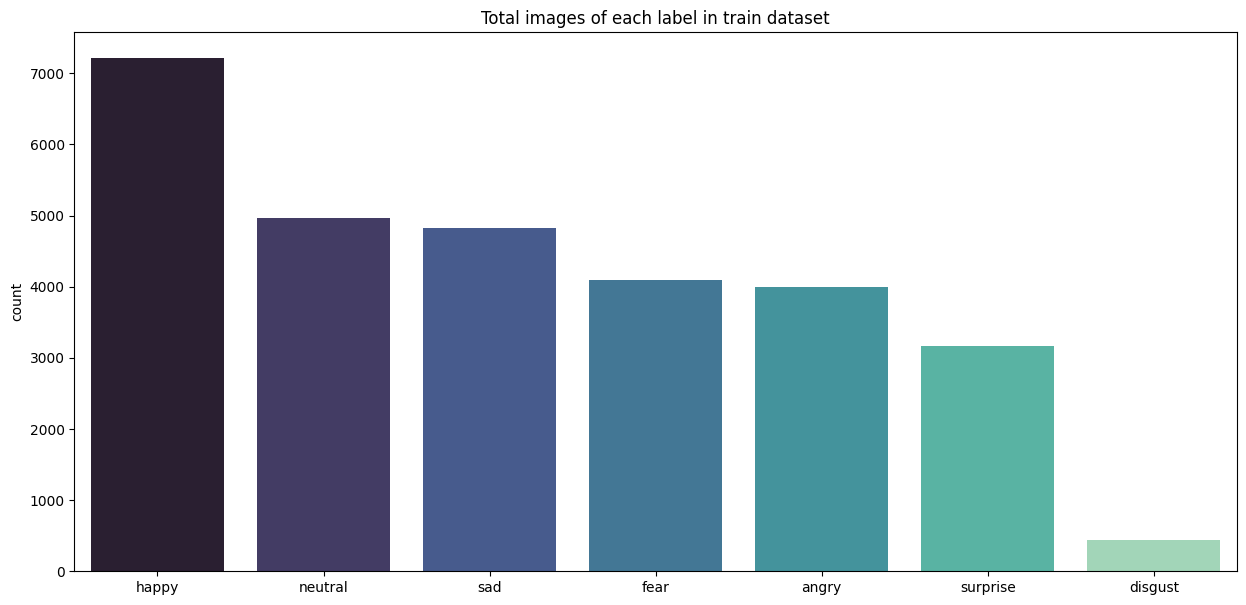

In [42]:
df = {}
for i in os.listdir(train_dir):
    directory = train_dir + i
    df[i] = len(os.listdir(directory))
df = pd.DataFrame(df, index=["total"]).transpose().sort_values("total", ascending=False)

plt.figure(figsize=(15,7))
sns.barplot(x=df.index, y="total", palette="mako", data=df)
plt.ylabel("count")
plt.title("Total images of each label in train dataset")
plt.show()

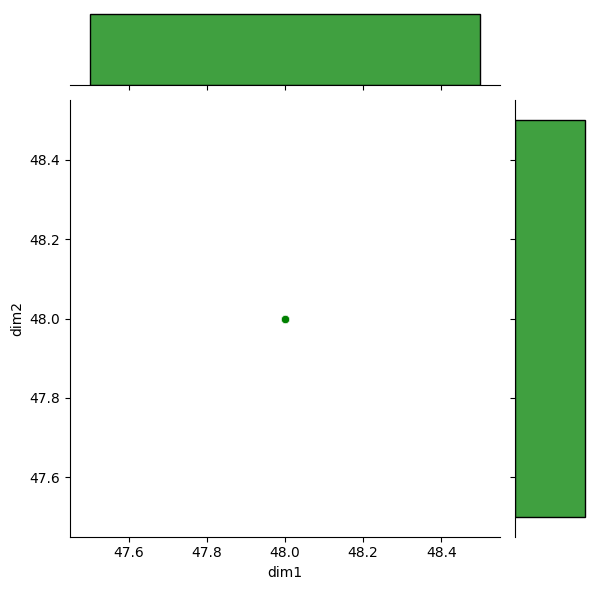

In [43]:
happy = os.listdir(train_dir+'happy/')
dim1, dim2 = [], []

for img_filename in happy:
    img = imread(train_dir+'happy/'+img_filename)
    d1, d2 = img.shape
    dim1.append(d1)
    dim2.append(d2)

df = pd.DataFrame({'dim1': dim1, 'dim2': dim2})
sns.jointplot(data=df, x='dim1', y='dim2', color='g')
plt.show()

In [44]:
train_gen = ImageDataGenerator(rescale=1/255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1/255)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)

train_generator = train_gen.flow_from_directory(directory=train_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_gen.flow_from_directory(directory=test_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [45]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=img_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=len(os.listdir(train_dir)), activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_8 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_9 (Batc  (None, 24, 24, 128)     

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = test_generator.n // test_generator.batch_size
num_epochs = 20

history = model.fit(train_generator,
                    epochs=num_epochs,
                    verbose=1,
                    #callbacks=callbacks,
                    validation_data=test_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

In [60]:
model.save("D:/major projects shivani/ML Facial recognition to detect mood and suggest songs accordingly/model.h5")

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print("validation accuracy :", str(test_acc*100)+"%")
print("validation loss :", test_loss)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'g', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'g', label='Training loss')
ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()

113/113 [==============================] - 45s 396ms/step
              precision    recall  f1-score   support

       angry       0.13      0.00      0.01       958
     disgust       0.02      0.88      0.03       111
        fear       0.00      0.00      0.00      1024
       happy       0.27      0.13      0.17      1774
     neutral       0.00      0.00      0.00      1233
         sad       0.00      0.00      0.00      1247
    surprise       0.16      0.03      0.04       831

    accuracy                           0.05      7178
   macro avg       0.08      0.15      0.04      7178
weighted avg       0.10      0.05      0.05      7178





C:\Users\shivani\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shivani\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shivani\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

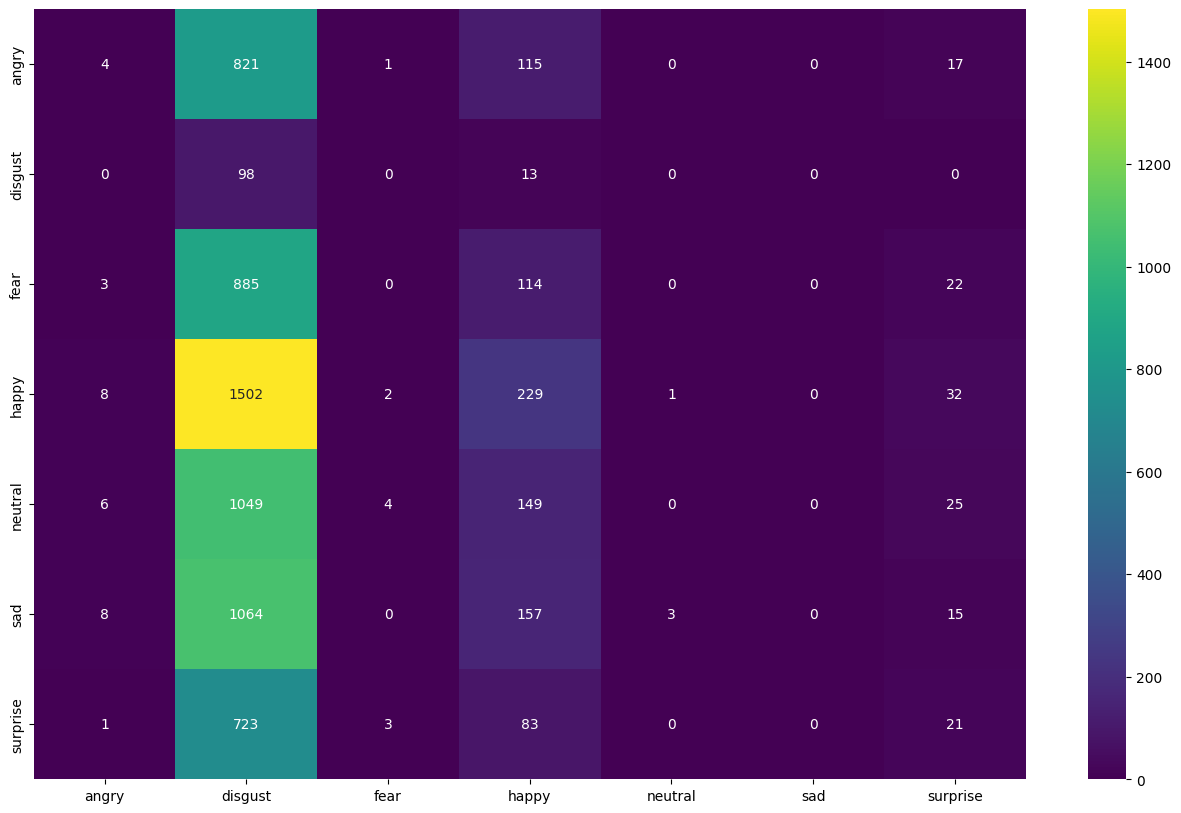

In [63]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(test_generator), axis=-1)
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()), end='\n\n\n')

cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(16,10))
sns.heatmap(cm, cmap=plt.cm.viridis, annot=True, fmt='.0f', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.show()

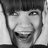

In [64]:
image = cv2.imread("D:/major projects shivani/ML Facial recognition to detect mood and suggest songs accordingly/test/surprise/PrivateTest_23067313.jpg")
from IPython.display import Image
Image(filename='D:/major projects shivani/ML Facial recognition to detect mood and suggest songs accordingly/test/surprise/PrivateTest_23067313.jpg')

In [65]:
import cv2
from tensorflow.python.keras.models import load_model
import os

# Load the trained model
model = tf.keras.models.load_model("D:/major projects shivani/ML Facial recognition to detect mood and suggest songs accordingly/model.h5",
                                   custom_objects={'Functional': tf.keras.models.Model})
# A list of emoticon categories
EMOTIONS = ['Angry', 'Disgust', 'Happy', 'Sad', 'Surprise', 'Neutral']
# Load image
img = image

# Trim the image to 48 x 48, convert to grayscale, and normalize
frame = cv2.resize(img, (48, 48), interpolation=cv2.INTER_LINEAR)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255.0

# Reshape the image dimension
gray = gray.reshape(1, 48, 48, 1)

# Output the prediction
predicts = model.predict(gray)[0]
label = EMOTIONS[predicts.argmax()]
for (i, j) in zip(range(7), EMOTIONS):
    predictss = predicts[i]
    print("{:^10s}".format(j) + " prediction rate is   {0:.2f}%".format(predictss))
print("\n\n The system considers this expression to be:", label)

1/1 [==============================] - 0s 432ms/step
  Angry    prediction rate is   0.14%
 Disgust   prediction rate is   0.14%
  Happy    prediction rate is   0.14%
   Sad     prediction rate is   0.14%
 Surprise  prediction rate is   0.14%
 Neutral   prediction rate is   0.14%


 The system considers this expression to be: Disgust


In [ ]:
import random
from IPython.display import Audio, display

if label == 'Angry':
    path = "D:\\major projects shivani\\ML Facial recognition to detect mood and suggest songs accordingly\\Angry"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename='D:\\major projects shivani\\ML Facial recognition to detect mood and suggest songs accordingly\\Angry\\' + d, autoplay=True)
    display(audio)

elif label == 'Disgust':
    path = "D:\\major projects shivani\\ML Facial recognition to detect mood and suggest songs accordingly\\Disgust\\"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename='D:\\major projects shivani\\ML Facial recognition to detect mood and suggest songs accordingly\\Disgust\\' + d, autoplay=True)
    display(audio)

elif label == "Happy":
    path = "D:\\major projects shivani\\ML Facial recognition to detect mood and suggest songs accordingly\\Happy\\"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename='D:\\major projects shivani\\ML Facial recognition to detect mood and suggest songs accordingly\\Happy\\' + d, autoplay=True)
    display(audio)

elif label == 'Sad':
    path = "D:\\major projects shivani\\ML Facial recognition to detect mood and suggest songs accordingly\\Sad\\"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename='D:\\major projects shivani\\ML Facial recognition to detect mood and suggest songs accordingly\\Sad\\' + d, autoplay=True)
    display(audio)

elif label == 'Surprise':
    path = "D:\\major projects shivani\\ML Facial recognition to detect mood and suggest songs accordingly\\Surprise\\"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename='D:\\major projects shivani\\ML Facial recognition to detect mood and suggest songs accordingly\\Surprise\\' + d, autoplay=True)
    display(audio)

elif label == 'Neutral':
    path = "D:\\major projects shivani\\ML Facial recognition to detect mood and suggest songs accordingly\\Neutral\\"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename='D:\\major projects shivani\\ML Facial recognition to detect mood and suggest songs accordingly\\Neutral\\' + d, autoplay=True)
    display(audio)